# Species Distribution Modeling

In [1]:
using SimpleSDMLayers
using Plots
using StatsPlots
using Statistics
using StatsBase
using Rasters
using GeoArrays
using CSV
using DataFrames
using Random
using Distributions

┌ Info: Loading DataFrames support for SimpleSDMLayers.jl
└ @ SimpleSDMLayers /home/csatol/.julia/packages/SimpleSDMLayers/lYDIT/src/SimpleSDMLayers.jl:107


# I. Data read and mapping

## 1. Brief presentation of Environmental Variables


The bioclimatic variables (version 1.4) from the WorldClim platform (Hijmans, Cameron, Parra, Jones, & Jarvis, 2005) were used as environmental variables for the SDMs. The raster dataset has 1x1 km resolution, and it contains 19 variables (raster stack layers):

    1. Annual Mean Temperature: degrees celsius.
    2. Annual Mean Diurnal Range the mean of the monthly temperature ranges (monthly maximum minus monthly minimum). Degrees celsius.
    3. Isothermality:  Isothermality quantifies how large the dayto-night temperatures oscillate relative to the summerto-winter (annual) oscillations. Units: percent.
    4. Temperature Seasonality (Standard Deviation): degrees celsius; the original data is multiplied by 100. 
    5. Max Temperature of Warmest Month: The maximum monthly temperature occurrence over a given year (time-series) or averaged span of years (normal). Units: degrees celsius.
    6. Min Temperature of Coldest Month: The minimum monthly temperature occurrence over a given year (time-series) or averaged span of years (normal). Units: degrees celsius.
    7. Annual Temperature Range: A measure of temperature variation over a given period. Units: degrees celsius.
    8. Mean Temperature of Wettest Quarter: This quarterly index approximates mean temperatures that prevail during the wettest season. Units: degrees celsius.
    9. Mean Temperature of Driest Quarter: This quarterly index approximates mean temperatures that prevail during the driest quarter. Units: degrees celsius.
    10. Mean Temperature of Warmest Quarter: This quarterly index approximates mean temperatures that prevail during the warmest quarter. Units: degrees celsius.
    11. Mean Temperature of Coldest Quarter: This quarterly index approximates mean temperatures that prevail during the coldest quarter. Units: degrees celsius.
    12. Annual Precipitation: This is the sum of all total monthly precipitation values. Units: Millimeters
    13. Precipitation of Wettest Month: This index identifies the total precipitation that prevails during the wettest month. Units: Millimeters.
    14. Precipitation of Driest Month: This index identifies the total precipitation that prevails during the driest month. Units: Millimeters.
    15. Precipitation Seasonality (CV): This is a measure of the variation in monthly precipitation totals over the course of the year. Units: percent. 
    16. Precipitation of Wettest Quarter: This quarterly index approximates total precipitation that prevails during the wettest quarter. Units: Millimeters.
    17. Precipitation of Driest Quarter: This quarterly index approximates total precipitation that prevails during the driest quarter. Units: Millimeters.
    18. Precipitation of Warmest Quarter: This quarterly index approximates total precipitation that prevails during the warmest quarter. Units: Millimeters.
    19. Precipitation of Coldest Quarter: This quarterly index approximates total precipitation that prevails during the coldest quarter. Units: Millimeters.

## 2. Reading the raster stack

In [2]:
bioclim = RasterStack("bioclim_romania/Bioclim_raster_to_Romania_WGS84.tif")

RasterStack with dimensions: 
  X Projected range(16.8083, stop=28.5167, length=1406) ForwardOrdered Regular Intervals crs: WellKnownText,
  Y Projected range(50.8167, stop=43.45, length=885) ReverseOrdered Regular Intervals crs: WellKnownText,
  Band Categorical 1:19 ForwardOrdered
and 1 layer:
  :layer1 Float32 dims: X, Y, Band (1406×885×19)

with metadata Metadata{Rasters.GDALfile} of Dict{Symbol, Any} with 3 entries:
  :offset   => 0.0
  :scale    => 1.0
  :filepath => "bioclim_romania/Bioclim_raster_to_Romania_WGS84.tif"

## 3. Reading the Smooth newt presence data and mapping

In [3]:
ampelensis = Matrix(CSV.read("input_data/ampelensis_data_WGS84.csv", DataFrame))
vulgaris = Matrix(CSV.read("input_data/vulgaris_data_WGS84.csv", DataFrame))

ampelensis = ampelensis[:, 3:4]
vulgaris = vulgaris[:, 3:4];

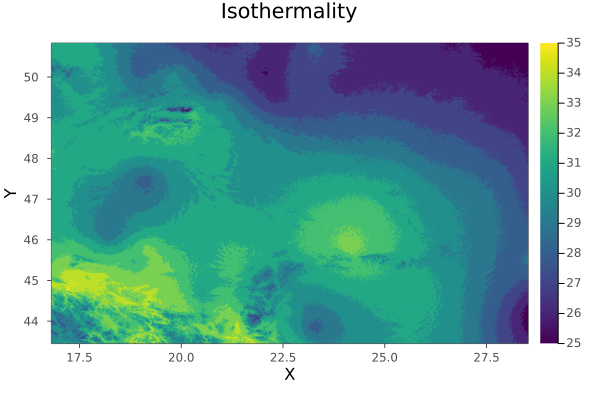

In [4]:
p = plot(bioclim[:, :, 3], title = "Isothermality", c = :viridis)

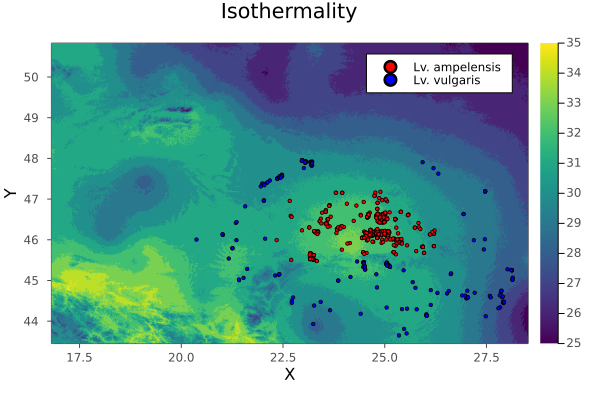

In [5]:
scatter!(p, ampelensis[:,1], ampelensis[:,2], markersize = 2, c = :red, label = "Lv. ampelensis")
scatter!(p, vulgaris[:,1], vulgaris[:,2], markersize = 2, c = :blue, label = "Lv. vulgaris")

In [5]:
@info "Number of samples for Lv. ampelensis" size(ampelensis)[1]
@info "Number of samples for Lv. vulgaris" size(vulgaris)[1]

┌ Info: Number of samples for Lv. ampelensis
│   (size(ampelensis))[1] = 411
└ @ Main In[5]:1
┌ Info: Number of samples for Lv. vulgaris
│   (size(vulgaris))[1] = 226
└ @ Main In[5]:2


# Challenges need to be addressed

## 1. 

In [6]:
Random.seed!(3576)

function randomSampling(xlim, ylim, n_samples = 10_000)
    x_coords = rand(Uniform(xlim[1], xlim[2]), n_samples)
    y_coords = rand(Uniform(ylim[1], ylim[2]), n_samples)
    return hcat(x_coords, y_coords)
end

randomSampling([1,5], [10, 20], 5)

5×2 Matrix{Float64}:
 4.24275  11.3392
 2.82257  11.908
 3.95408  12.7094
 1.31836  10.3068
 1.47869  13.0252

In [7]:
raster_xlim = [minimum(Array(dims(bioclim)[1])), maximum(Array(dims(bioclim)[1]))]
raster_ylim = [minimum(Array(dims(bioclim)[2])), maximum(Array(dims(bioclim)[2]))]

2-element Vector{Float64}:
 43.45
 50.81666666666667

In [8]:
Random.seed!(3576)

pseudo_absence = randomSampling(raster_xlim, raster_ylim, 10_000);

In [9]:
size(pseudo_absence)

(10000, 2)

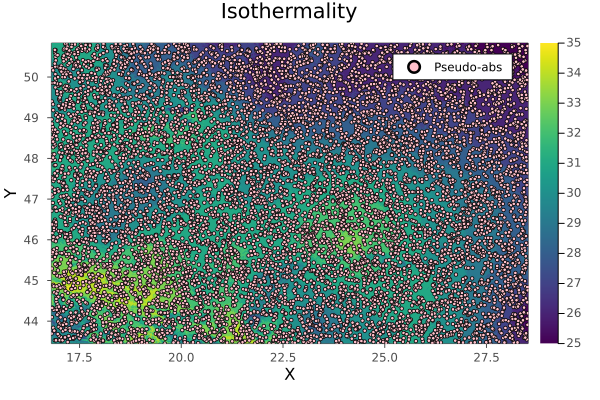

In [10]:
scatter!(p, pseudo_absence[:,1], pseudo_absence[:,2], markersize = 2, c = :pink, label = "Pseudo-obs")

## $\Theta$ - $r_i$ mátrix létrehozása

**Itt úgy emlékszem, hogy azt beszéltük, hogy a pseudo-absence pontoknak adok random értéket elsősorban 0 és egy kicsi szám között.**

In [11]:
function extractValues(points, raster, state, rand_min = 0, rand_max = 0.1)
    nrow = size(points)[1]
    output = Array(extract(raster, points[1,:])[3])
    
    xlim = [minimum(Array(dims(raster)[1])), maximum(Array(dims(raster)[1]))]
    ylim = [minimum(Array(dims(raster)[2])), maximum(Array(dims(raster)[2]))]
    
    
    if nrow > 1
        for i ∈ 2:nrow
           
            if xlim[1] <= points[i,1] <= xlim[2] && ylim[1] <= points[i,2] <= ylim[2]
                temp = Array(extract(raster, points[i,:])[3]) # a harmadik elem az extract outputból tartalmazza a raszter értékeket
                output = hcat(output, temp)
                
            end
        end
    end
    
    if state == "absence"
       state_values = rand(Uniform(rand_min, rand_max), size(output)[2])    
    elseif state == "presence"
        state_values = ones(size(output)[2])
    end
    
    output = hcat(state_values, transpose(output))
    return output

end

extractValues(pseudo_absence[1:5, :], bioclim, "absence")

5×20 Matrix{Float64}:
 0.0132927    21.0   75.0  29.0  6525.0  …  31.0  470.0  226.0  470.0  241.0
 0.000826758  98.0   97.0  29.0  8599.0     38.0  211.0   91.0  203.0   92.0
 0.0650421    93.0  100.0  29.0  8457.0     42.0  217.0   76.0  207.0   76.0
 0.0664144    80.0   88.0  31.0  6994.0     47.0  243.0   75.0  243.0   77.0
 0.0534687    76.0   84.0  26.0  8198.0     42.0  237.0   82.0  237.0   87.0

In [12]:
theta_r_ampelensis = extractValues(ampelensis, bioclim, "presence")
theta_r_vulgaris = extractValues(vulgaris, bioclim, "presence")
theta_r_absence = extractValues(pseudo_absence, bioclim, "absence");

In [13]:
theta_r_newt = vcat(theta_r_ampelensis, theta_r_vulgaris)

631×20 Matrix{Float64}:
 1.0   55.0   93.0  30.0  7646.0  208.0  …  45.0  294.0  105.0  285.0  107.0
 1.0   53.0   93.0  30.0  7585.0  206.0     45.0  297.0  107.0  288.0  109.0
 1.0   55.0   93.0  30.0  7644.0  208.0     45.0  295.0  105.0  285.0  107.0
 1.0   55.0   93.0  30.0  7644.0  208.0     45.0  295.0  105.0  285.0  107.0
 1.0   49.0   93.0  31.0  7345.0  198.0     46.0  312.0  109.0  304.0  113.0
 1.0   55.0   93.0  30.0  7644.0  208.0  …  45.0  295.0  105.0  285.0  107.0
 1.0   56.0   94.0  30.0  7691.0  209.0     45.0  290.0  102.0  281.0  104.0
 1.0   96.0  108.0  33.0  7755.0  258.0     43.0  242.0   83.0  231.0   89.0
 1.0   93.0  109.0  32.0  7877.0  256.0     42.0  240.0   84.0  232.0   92.0
 1.0   51.0   93.0  31.0  7373.0  200.0     46.0  308.0  108.0  300.0  111.0
 1.0   56.0   94.0  30.0  7624.0  208.0  …  45.0  293.0  104.0  284.0  106.0
 1.0   72.0   99.0  30.0  7937.0  233.0     46.0  259.0   87.0  251.0   88.0
 1.0   72.0   99.0  30.0  7937.0  233.0     46.0  25